In [1]:
# Load the symbol to uniprot mapping
import json

# Load mapping dictionary
with open(r'C:\Users\abdul\OneDrive - University of Cambridge\Desktop\MDRA\cellbox_torch\Abdullah_kuziez\Experiments\raw_data\TNBC_set\symbol_to_uniprot.json', 'r') as f:
    symbol_to_uniprot = json.load(f)

print(f"Loaded {len(symbol_to_uniprot)} symbol-to-uniprot mappings")


Loaded 20311 symbol-to-uniprot mappings


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.cluster.hierarchy import linkage, leaves_list, fcluster
from collections import defaultdict
from scipy.stats import spearmanr, pearsonr
import requests

14 cell lines
['DU4475' 'MCF7' 'MDA-MB-436' 'HCC1806' 'HS578T' 'HCC1395' 'T47D' 'HCC70'
 'MDA-MB-453(ATCC)' 'BT549' 'HCC1143' 'MDA-MB-453' 'HCC1937' 'BT20']
DU4475: 516 samples
MCF7: 408 samples
HS578T: 357 samples
HCC70: 417 samples
BT549: 534 samples
MDA-MB-453: 516 samples


C:\Users\abdul\AppData\Local\Temp\ipykernel_45564\2644187085.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(all_sample_counts.keys()), y=list(all_sample_counts.values()), palette="viridis")


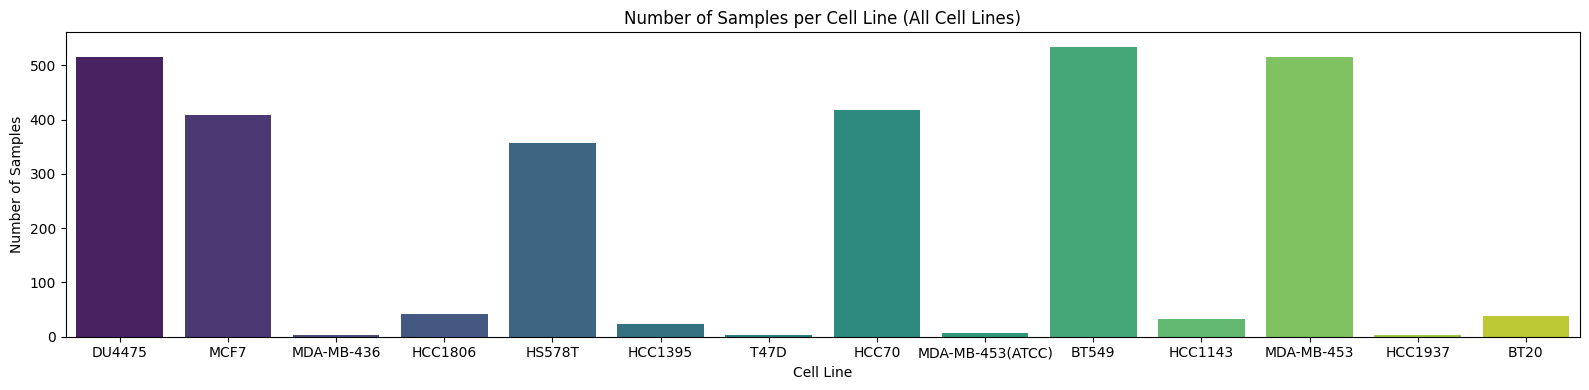

<Figure size 640x480 with 0 Axes>

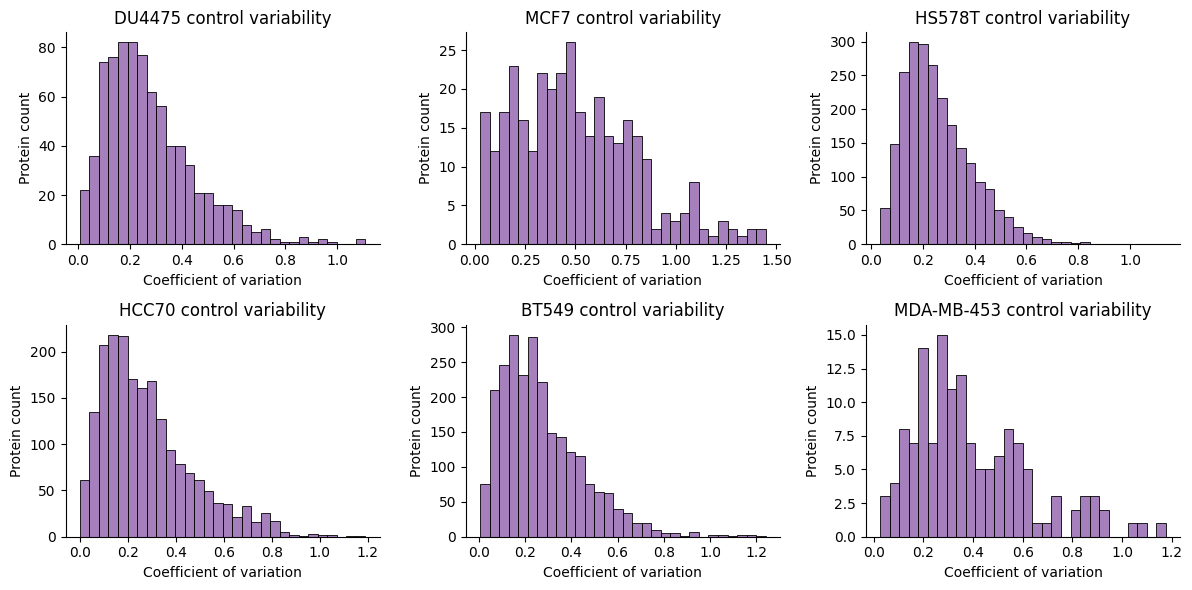

In [3]:
#loading data and making dicts
data = pd.read_csv(r"C:\Users\abdul\OneDrive - University of Cambridge\Desktop\MDRA\cellbox_torch\Abdullah_kuziez\Experiments\raw_data\TNBC_set\PTV1_protein_matrix_test.cleaned.tsv", index_col=0, sep="\t")
data.head()

# Load screen information
screen_info = pd.read_excel(r"C:\Users\abdul\OneDrive - University of Cambridge\Desktop\MDRA\cellbox_torch\Abdullah_kuziez\Experiments\raw_data\TNBC_set\PTV1_sample_info_test.xlsx", sheet_name=0)  # First sheet is single perturbation info
screen_info.head()

# Get unique cell lines
cell_lines = pd.unique(screen_info["cell_line"])
print(f"{len(cell_lines)} cell lines")
print(cell_lines)
# Get sample IDs corresponding to controls for each cell line
control_ids = {}
for cell_line in cell_lines:
    control_ids[cell_line] = list(screen_info.loc[(screen_info["cell_line"] == cell_line) & (screen_info["pert_id"] == "no"), "Sample_ID"].values)

# Segment data by cell line and remove lines with fewer than 100 samples
data_by_cell_line = {}
for cell_line in cell_lines:
    data_cell = data.loc[:, screen_info.loc[screen_info["cell_line"] == cell_line, "Sample_ID"]]
    if data_cell.shape[1] >= 100:
        data_by_cell_line[cell_line] = data_cell
        print(f"{cell_line}: {data_by_cell_line[cell_line].shape[1]} samples")
cell_lines = list(data_by_cell_line.keys())


# Get control samples for each cell line
control_data = {}
for cell_line in cell_lines:
    control_cell = data_by_cell_line[cell_line][control_ids[cell_line]]
    
    # Drop rows with missing values
    control_cell = control_cell.dropna()
    control_data[cell_line] = control_cell

#basic graphs of data
all_sample_counts = {cell_line: data.loc[:, screen_info.loc[screen_info["cell_line"] == cell_line, "Sample_ID"]].shape[1] for cell_line in pd.unique(screen_info["cell_line"])}
plt.figure(figsize=(16, 4))
sns.barplot(x=list(all_sample_counts.keys()), y=list(all_sample_counts.values()), palette="viridis")
plt.xlabel("Cell Line")
plt.ylabel("Number of Samples")
plt.title("Number of Samples per Cell Line (All Cell Lines)")
plt.tight_layout()
plt.show()

    # Generate plots of control variability for each gene across replicates for each cell line
plt.clf()
# Arrange figures in a 2x3 grid (2 rows, 3 columns)
n_rows, n_cols = 2, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))
axes = axes.flatten()

for i, cell_line in enumerate(cell_lines):
    control_cell = control_data[cell_line]
    control_cell["Standard deviation"] = control_cell.std(axis=1)
    # Compute coefficient of variation
    control_cell["Coefficient of variation"] = control_cell["Standard deviation"] / control_cell.mean(axis=1)
    sns.histplot(control_cell["Coefficient of variation"], bins=30, color="#8856a7", ax=axes[i])
    sns.despine(ax=axes[i])
    axes[i].set_title(f"{cell_line} control variability")
    axes[i].set_xlabel("Coefficient of variation")
    axes[i].set_ylabel("Protein count")

# Hide any unused subplots
for j in range(len(cell_lines), n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
